In [1]:
import qai_hub as hub
import torch
import requests
import numpy as np
from PIL import Image

from modules.xfeat import XFeat

In [2]:
torch_model = XFeat()
torch_model.eval()

loading weights from: /home/raghav/Vilota/xfeat_artifacts/accelerated_features/modules/../weights/xfeat.pt


XFeat(
  (net): XFeatModel(
    (norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (skip1): Sequential(
      (0): AvgPool2d(kernel_size=4, stride=4, padding=0)
      (1): Conv2d(1, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (block1): Sequential(
      (0): BasicLayer(
        (layer): Sequential(
          (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): BasicLayer(
        (layer): Sequential(
          (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): BasicLayer(
        (layer): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding

In [3]:
# Step 1: Trace model
input_shape = (1, 3, 320, 320)
example_input = torch.rand(input_shape)
traced_torch_model = torch.jit.trace(torch_model.net, example_input)

In [8]:
# Step 2: Compile model
compile_job = hub.submit_compile_job(
    model=traced_torch_model,
    device=hub.Device("RB3 Gen 2 (Proxy)"),
    input_specs=dict(image=input_shape),
)
target_model = compile_job.get_target_model()

Uploading tmp4312shej.pt


100%|██████████| 6.16M/6.16M [00:02<00:00, 3.17MB/s]


Scheduled compile job (jp3v1n2zg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp3v1n2zg/

Waiting for compile job (jp3v1n2zg) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


In [ ]:
# Step 3: Profile on cloud-hosted device
profile_job = hub.submit_profile_job(
    model=target_model,
    device=hub.Device("RB3 Gen 2 (Proxy)"),
)

In [9]:
# Step 4: Run inference on cloud-hosted device
sample_image_url = (
    "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/input_image1.jpg"
)
response = requests.get(sample_image_url, stream=True)
response.raw.decode_content = True
image = Image.open(response.raw).resize((320, 320))

# Convert to numpy array
image = np.array(image)
# Convert to tensor
image = torch.tensor(image).permute(2, 0, 1)[None]

input_array = torch_model.preprocess_tensor(image)[0]

In [10]:
# Run inference using the on-device model on the input image
inference_job = hub.submit_inference_job(
    model=target_model,
    device=hub.Device("RB3 Gen 2 (Proxy)"),
    inputs=dict(image=[input_array.numpy()]),
)
on_device_output = inference_job.download_output_data()

Uploading dataset: 264kB [00:01, 204kB/s]                    <?, ?B/s]


Scheduled inference job (jgoknzqdp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgoknzqdp/

Waiting for inference job (jgoknzqdp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


tmp5ss40sbv.h5: 100%|██████████| 604k/604k [00:00<00:00, 1.21MB/s]


In [11]:
for key, value in on_device_output.items():
    print(f"Output key: {key}")
    print(f"Output shape: {value[0].shape}")
    print(f"Output dtype: {value[0].dtype}")

import pickle

with open("output.pkl", "wb") as f:
    pickle.dump(on_device_output, f)

Output key: output_0
Output shape: (1, 64, 40, 40)
Output dtype: float32
Output key: output_1
Output shape: (1, 65, 40, 40)
Output dtype: float32
Output key: output_2
Output shape: (1, 1, 40, 40)
Output dtype: float32


In [3]:
# Step 5: Post-processing the on-device output

import pickle

# Load the object from the pickle file
with open("output.pkl", "rb") as file:
    loaded_data = pickle.load(file)

# for key, value in loaded_data.items():
#     print(f"Output key: {key}")
#     print(f"Output shape: {value[0].shape}")
#     print(f"Output dtype: {value[0].dtype}")

M1 = torch.from_numpy(loaded_data["output_0"][0]) # feature_descriptors
K1 = torch.from_numpy(loaded_data["output_1"][0]) # keypoints
H1 = torch.from_numpy(loaded_data["output_2"][0]) # reliability heatmaps

out = torch_model.detectAndComputeFrontEnd({
    "M1": M1,
    "K1": K1,
    "H1": H1,
})[0]

print(out.keys())

dict_keys(['keypoints', 'descriptors'])


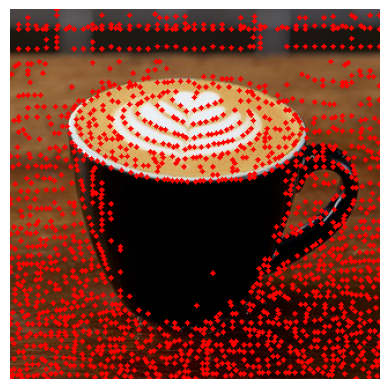

In [8]:
# Display data
import cv2
import matplotlib.pyplot as plt

def displayPoints(frame, points):
    color1 = (255, 0, 0)
    for i, point in enumerate(points):
        cv2.circle(frame, (int(point[0]), int(point[1])), 2, color1, -1)
        # cv2.putText(frame, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255))
    return frame

sample_image_url = (
    "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/input_image1.jpg"
)
response = requests.get(sample_image_url, stream=True)
response.raw.decode_content = True
image = Image.open(response.raw).resize((320, 320))

# Convert to numpy array
image = np.array(image)

# Draw keypoints
image = displayPoints(image, out["keypoints"])

# Display the image
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

In [15]:
# Step 6: Download model
target_model = compile_job.get_target_model()
target_model.download("xfeat.tflite")

xfeat.tflite: 100%|██████████| 2.58M/2.58M [00:00<00:00, 3.37MB/s]

Downloaded model to xfeat.tflite


'xfeat.tflite'